**Inteligência Artifical**

**812839 - Vinícius Miranda de Araújo**

**Lista de Exercícios 10**

---
---

## Utils - Classe Para Gerar .gif

In [1]:
!pip install imageio

In [2]:
!pip install matplotlib

In [8]:
import os
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

class GifLogger:
    def __init__(self, inputs, expected_outputs, perceptron_model,
                 x_margin=1, y_margin=1, frames_per_second=2):
        """
        Inicializa o logger para gerar GIFs durante o treinamento do perceptron.

        :param inputs: Conjunto de dados de entrada
        :param expected_outputs: Saídas esperadas (rótulos)
        :param perceptron_model: Instância do perceptron
        :param x_margin: Margem extra no eixo X para visualização
        :param y_margin: Margem extra no eixo Y
        :param frames_per_second: Taxa de quadros por segundo para o GIF
        """
        self.inputs = inputs
        self.labels = expected_outputs
        self.perceptron = perceptron_model
        self.frames_folder = "frames"
        self.gif_folder = "gifs"
        self.saved_frame_paths = []
        self.fps = frames_per_second

        input_array = np.array(inputs)
        self.x_min = input_array[:, 0].min() - x_margin
        self.x_max = input_array[:, 0].max() + x_margin
        self.y_min = input_array[:, 1].min() - y_margin
        self.y_max = input_array[:, 1].max() + y_margin

        os.makedirs(self.frames_folder, exist_ok=True)
        os.makedirs(self.gif_folder, exist_ok=True)
    # __init__

    def save_frame(self, epoch):
        plt.figure(figsize=(8, 6))

        for i, point in enumerate(self.inputs):
            color = 'red' if self.labels[i] == 0 else 'blue'
            label = f'Class {self.labels[i]}' if i == 0 else ""
            plt.scatter(point[0], point[1], color=color, label=label)

        x_values = np.linspace(self.x_min, self.x_max, 100)

        if abs(self.perceptron.weights[1]) < 1e-6:
            x_constant = -self.perceptron.bias_weight / (self.perceptron.weights[0] if abs(self.perceptron.weights[0]) > 1e-6 else 1e-6)
            plt.axvline(x=x_constant, color='green', label='Decision Boundary')
        else:
            slope = -self.perceptron.weights[0] / self.perceptron.weights[1]
            intercept = -self.perceptron.bias_weight / self.perceptron.weights[1]
            y_values = slope * x_values + intercept
            plt.plot(x_values, y_values, label='Decision Boundary', color='green')

        plt.title(f'Epoch {epoch + 1}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.grid(True)

        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)

        frame_path = os.path.join(self.frames_folder, f"frame_{epoch}.png")
        plt.savefig(frame_path)
        plt.close()

        self.saved_frame_paths.append(frame_path)
    # save_frame

    def generate_gif(self, output_filename="perceptron_training.gif"):
        output_path = os.path.join(self.gif_folder, output_filename)
        images = [imageio.imread(frame) for frame in self.saved_frame_paths]
        imageio.mimsave(output_path, images, fps=self.fps)

        for frame in self.saved_frame_paths:
            os.remove(frame)
        if os.path.exists(self.frames_folder):
            os.rmdir(self.frames_folder)

        print(f"GIF saved as {output_path}")
    # generate_gif
# GifLogger

## **Questão 1**

---

### Implementação do Perceptron

In [9]:
import random
# from gif_generator import GifLogger

class Perceptron:
    def __init__(self, num_inputs: int, learning_rate: float = 0.1, random_seed: int = None) -> None:
        """
        Inicializa o perceptron com o número de entradas especificado.

        :param num_inputs: Número de entradas
        :param learning_rate: Taxa de aprendizado
        :param random_seed: Semente para geração de números aleatórios
        """
        if random_seed is not None:
            random.seed(random_seed)

        self.num_inputs = num_inputs
        self.learning_rate = learning_rate
        self.weights = [0] * num_inputs
        self.bias_weight = random.uniform(-1, 1)

        self._initialize_weights()
    # __init__

    def _initialize_weights(self) -> None:
        """
        Inicializa os pesos com valores aleatórios entre -1 e 1.
        """
        for i in range(self.num_inputs):
            self.weights[i] = random.uniform(-1, 1)
    # _initialize_weights

    def _activation_function(self, value: float) -> int:
        """
        Função de ativação do perceptron

        :param value: Valor de entrada
        :return: 1 se valor > 0, caso contrário 0
        """
        return 1 if value > 0 else 0
    # _activation_function

    def _compute_weighted_sum(self, input_vector) -> float:
        """
        Calcula a soma ponderada das entradas mais o bias.

        :param input_vector: Vetor de entrada
        :return: Soma ponderada
        """
        weighted_sum = sum(input_vector[i] * self.weights[i] for i in range(self.num_inputs))
        weighted_sum += self.bias_weight
        return weighted_sum
    # _compute_weighted_sum

    def _compute_error(self, expected: float, predicted: float) -> float:
        """
        Calcula o erro como a diferença entre esperado e previsto.

        :param expected: Valor esperado
        :param predicted: Valor previsto
        :return: Erro
        """
        return expected - predicted
    # _compute_error

    def _adjust_weights(self, input_vector, error: float) -> None:
        """
        Ajusta os pesos com base no erro.

        :param input_vector: Vetor de entrada
        :param error: Erro de previsão
        """
        for i in range(self.num_inputs):
            self.weights[i] += self.learning_rate * error * input_vector[i]
        self.bias_weight += self.learning_rate * error
    # _adjust_weights

    def _predict_single(self, input_vector) -> float:
        """
        Faz uma previsão para uma única entrada.

        :param input_vector: Vetor de entrada
        :return: Previsão (0 ou 1)
        """
        weighted_sum = self._compute_weighted_sum(input_vector)
        return self._activation_function(weighted_sum)
    # _predict_single

    def train(self, input_data, expected_outputs, num_epochs: int,
              verbose: bool = False,
              generate_gif: bool = False, gif_name: str = "perceptron_training.gif") -> list:
        """
        Treina o perceptron usando os dados fornecidos.

        :param input_data: Lista de vetores de entrada
        :param expected_outputs: Lista de saídas esperadas
        :param num_epochs: Número de épocas de treinamento
        :param verbose: Mostra informações do treinamento se True
        :param generate_gif: Gera gif do processo de treinamento se True
        :param gif_name: Nome do arquivo GIF
        :return: Instância do perceptron treinado
        """
        epoch = 0
        predictions = []
        logger = GifLogger(input_data, expected_outputs, self) if generate_gif else None

        while predictions != expected_outputs and epoch < num_epochs:
            predictions = []
            for i in range(len(input_data)):
                predicted = self._predict_single(input_data[i])
                error = self._compute_error(expected_outputs[i], predicted)
                predictions.append(predicted)

                if error != 0:  # Atualiza apenas se houver erro
                    self._adjust_weights(input_data[i], error)

            epoch += 1

            if verbose:
                print(f'\nÉpoca {epoch}')
                print("-" * 20)
                print(f'Pesos: {self.weights}')
                print(f'Peso do Bias: {self.bias_weight}')
                print(f'Saída esperada: {expected_outputs}')
                print(f'Saída prevista: {predictions}')

            if generate_gif:
                logger.save_frame(epoch)

        if generate_gif:
            logger.generate_gif(output_filename=gif_name)

        return self
    # train
# Perceptron

### Explicação da Implementação

- A classe `Perceptron` implementa um modelo de rede neural bem simples, o perceptron de camada única. Ele é usado para resolver problemas de classificação binária, ou seja, onde o objetivo é decidir entre duas classes (por exemplo, "sim" ou "não").

- O perceptron tenta encontrar uma reta (ou uma linha de decisão) que separa corretamente os exemplos de uma classe dos exemplos da outra classe.

- Passo a Passo:

  1. Inicialização (`__init__`)

    - O construtor define:

      - Quantas entradas (inputs) o modelo deve esperar.
      
      - Qual será a taxa de aprendizado (ou seja, o quanto os pesos
      mudam a cada erro).
      
      - E se uma semente aleatória foi passada, ele usa isso para garantir que os resultados sejam reproduzíveis.
    
    - Os pesos são números que representam a importância de cada entrada. Eles são iniciados com valores aleatórios.
    
    - Também existe um bias — um peso extra que não depende das entradas, mas ajuda o modelo a ajustar melhor a linha de separação.

  2. Função de ativação

    - Ela é chamada sempre que o perceptron precisa tomar uma decisão.
    
    - O modelo soma os produtos de cada entrada pelo seu peso, adiciona o bias e passa o resultado por uma função que devolve:

      - `1` se o valor for positivo,
      
      - `0` caso contrário.

  3. Treinamento

    - O perceptron é treinado comparando suas previsões com os resultados esperados.
    
    - Se a previsão estiver errada, os pesos são atualizados de acordo com a diferença entre o valor previsto e o valor real.
    
    - Esse processo se repete por várias “épocas” — rodadas completas sobre os dados de entrada.
    
    - O treinamento para quando o perceptron acerta todos os exemplos ou quando atinge o número máximo de épocas.

  4. Visualização (opcional)

    - Se o parâmetro `generate_gif` for `True`, o perceptron vai capturar imagens do processo de treinamento para gerar um GIF ao final. Isso ajuda a visualizar como a linha de decisão evolui com o tempo.



### Resolvendo a Função AND

In [13]:
entradas = [[0, 0],
            [0, 1],
            [1, 0],
            [1, 1]]
saidas_esperadas = [0, 0, 0, 1]

perceptron_and = Perceptron(num_inputs=2, learning_rate=0.1, random_seed=42)
perceptron_and.train(entradas, saidas_esperadas, num_epochs=30, verbose=False, generate_gif=True, gif_name="AND_perceptron.gif")

GIF saved as gifs/AND_perceptron.gif


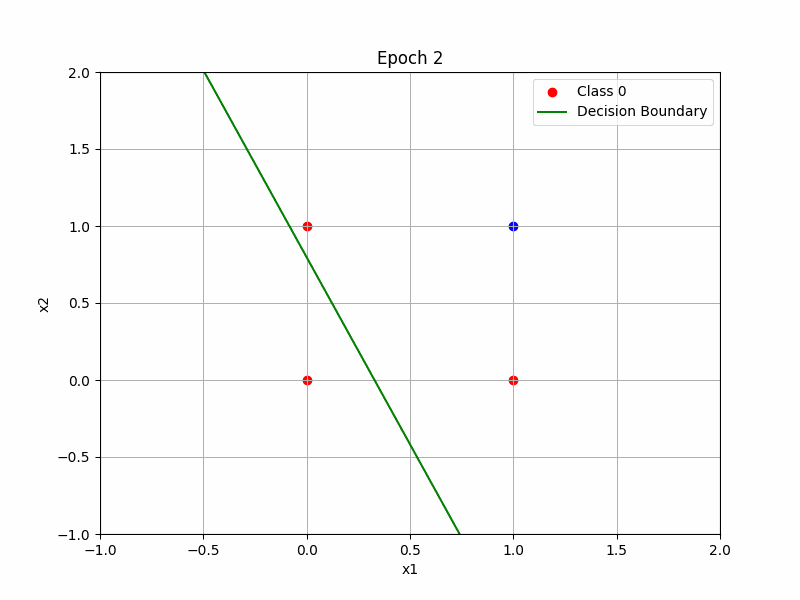


### Resolvendo a Função OR

In [14]:
entradas = [[0, 0],
            [0, 1],
            [1, 0],
            [1, 1]]
saidas_esperadas = [0, 1, 1, 1]

perceptron_or = Perceptron(num_inputs=2, learning_rate=0.1, random_seed=42)
perceptron_or.train(entradas, saidas_esperadas, num_epochs=30, verbose=False, generate_gif=True, gif_name="OR_perceptron.gif")

GIF saved as gifs/OR_perceptron.gif


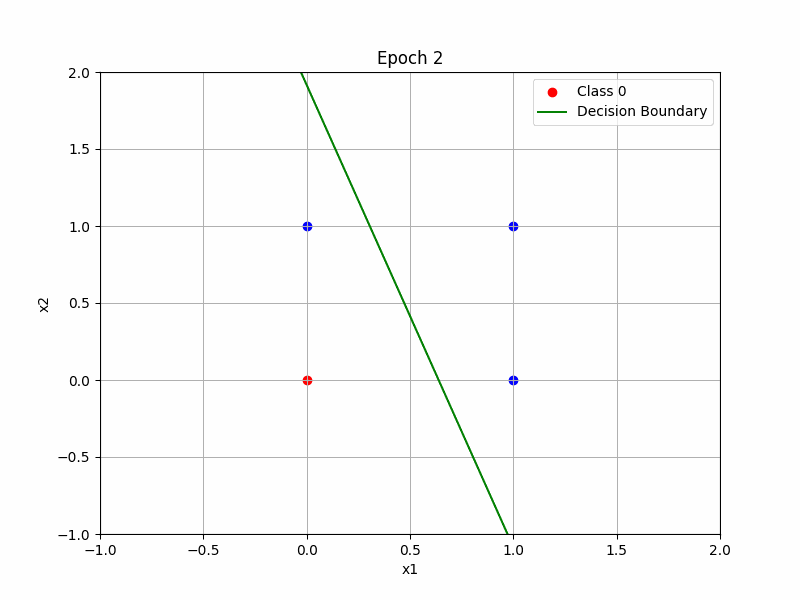

### Resolvendo a Função XOR

In [17]:
entradas = [[0, 0],
            [0, 1],
            [1, 0],
            [1, 1]]
saidas_esperadas = [0, 1, 1, 0]

perceptron_xor = Perceptron(num_inputs=2, learning_rate=0.1, random_seed=42)
perceptron_xor.train(entradas, saidas_esperadas, num_epochs=30, verbose=False, generate_gif=True, gif_name="XOR_perceptron.gif")

GIF saved as gifs/XOR_perceptron.gif


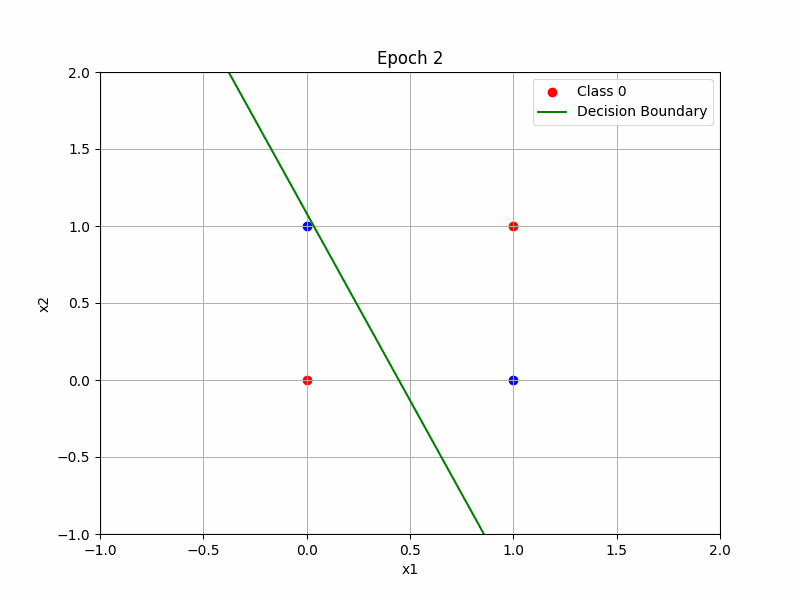

O Perceptron não resolve o XOR, pois não é um problema linearmente separável.

## **Questão 02**

---


### Implementação do BackPropagation

In [1]:
import numpy as np

class BackPropagation:
    def __init__(self, num_inputs, num_hidden_neurons, num_outputs,
                 learning_rate=0.1, activation_function='sigmoid', use_bias=True,
                 random_seed=None):
        """
        Inicializa a rede neural com os parâmetros fornecidos.
        :param num_inputs: Número de neurônios na camada de entrada
        :param num_hidden_neurons: Número de neurônios na camada oculta
        :param num_outputs: Número de neurônios na camada de saída
        :param learning_rate: Taxa de aprendizado para atualização dos pesos
        :param activation_function: Função de ativação a ser usada ('sigmoid', 'tanh', 'relu')
        :param use_bias: Se True, inclui bias nas camadas
        :param random_seed: Semente para reprodutibilidade (opcional)
        """
        if random_seed is not None:
            np.random.seed(random_seed)
        self.num_inputs = num_inputs
        self.num_hidden_neurons = num_hidden_neurons
        self.num_outputs = num_outputs
        self.learning_rate = learning_rate
        self.use_bias = use_bias
        self.activation_function_name = activation_function

        self._initialize_weights()

        self.training_loss_history = []

        self._initialize_activation_functions()
    # __init__

    def _initialize_weights(self):
        self.weights_input_to_hidden = np.random.uniform(-1, 1, (self.num_inputs, self.num_hidden_neurons))
        self.weights_hidden_to_output = np.random.uniform(-1, 1, (self.num_hidden_neurons, self.num_outputs))

        if self.use_bias:
            self.bias_hidden_layer = np.random.uniform(-1, 1, (1, self.num_hidden_neurons))
            self.bias_output_layer = np.random.uniform(-1, 1, (1, self.num_outputs))
        else:
            self.bias_hidden_layer = np.zeros((1, self.num_hidden_neurons))
            self.bias_output_layer = np.zeros((1, self.num_outputs))
    # _initialize_weights

    def _initialize_activation_functions(self):
        if self.activation_function_name == 'sigmoid':
            self.activation = self._sigmoid
            self.activation_derivative = self._sigmoid_derivative
        elif self.activation_function_name == 'tanh':
            self.activation = self._tanh
            self.activation_derivative = self._tanh_derivative
        elif self.activation_function_name == 'relu':
            self.activation = self._relu
            self.activation_derivative = self._relu_derivative
        else:
            raise ValueError(f"Função de ativação '{self.activation_function_name}' não suportada.")
    # _initialize_activation_functions

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def _sigmoid_derivative(self, x):
        sig = self._sigmoid(x)
        return sig * (1 - sig)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def _compute_loss(self, predictions, expected_output):
        return np.mean((predictions - expected_output) ** 2)

    def _compute_gradients(self, input_data, expected_output):
        """Calcula os gradientes para atualização dos pesos"""
        num_samples = input_data.shape[0]

        output_error = self.predicted_output - expected_output
        output_gradient = output_error  # derivada da MSE * sigmoide já aplicada na saída

        grad_weights_hidden_output = (1 / num_samples) * np.dot(self.hidden_output.T, output_gradient)
        grad_bias_output = (1 / num_samples) * np.sum(output_gradient, axis=0, keepdims=True)

        hidden_error = np.dot(output_gradient, self.weights_hidden_to_output.T)
        hidden_gradient = hidden_error * self.activation_derivative(self.hidden_input)

        grad_weights_input_hidden = (1 / num_samples) * np.dot(input_data.T, hidden_gradient)
        grad_bias_hidden = (1 / num_samples) * np.sum(hidden_gradient, axis=0, keepdims=True)

        return grad_weights_input_hidden, grad_bias_hidden, grad_weights_hidden_output, grad_bias_output
    # _compute_gradients

    def _adjust_weights(self, grad_w_ih, grad_b_h, grad_w_ho, grad_b_o):
        """
        Ajusta os pesos e bias da rede neural usando os gradientes calculados.
        :param grad_w_ih: Gradiente dos pesos da camada de entrada para a camada oculta
        :param grad_b_h: Gradiente do bias da camada oculta
        :param grad_w_ho: Gradiente dos pesos da camada oculta para a camada de saída
        :param grad_b_o: Gradiente do bias da camada de saída
        """
        self.weights_input_to_hidden -= self.learning_rate * grad_w_ih
        self.weights_hidden_to_output -= self.learning_rate * grad_w_ho

        if self.use_bias:
            self.bias_hidden_layer -= self.learning_rate * grad_b_h
            self.bias_output_layer -= self.learning_rate * grad_b_o
    # _adjust_weights

    def _forward_pass(self, input_data):
        """
        Executa a passagem direta pela rede neural.
        :param input_data: Dados de entrada (numpy array)
        :return: Saída prevista pela rede neural
        """
        self.hidden_input = np.dot(input_data, self.weights_input_to_hidden) + self.bias_hidden_layer
        self.hidden_output = self.activation(self.hidden_input)

        self.output_input = np.dot(self.hidden_output, self.weights_hidden_to_output) + self.bias_output_layer
        self.predicted_output = self._sigmoid(self.output_input)

        return self.predicted_output
    # _forward_pass

    def _backward_pass(self, input_data, expected_output):
        """
        Executa a passagem reversa para calcular os gradientes e atualizar os pesos.
        :param input_data: Dados de entrada (numpy array)
        :param expected_output: Saída esperada (numpy array)
        """
        gradients = self._compute_gradients(input_data, expected_output)
        self._adjust_weights(*gradients)
    # _backward_pass

    def train(self, input_data, expected_output, num_epochs=1000, verbose=False):
        """
        Treina a rede neural usando o algoritmo de retropropagação.
        :param input_data: Dados de entrada (numpy array)
        :param expected_output: Saída esperada (numpy array)
        :param num_epochs: Número de épocas para treinamento
        :param verbose: Se True, imprime o progresso do treinamento
        """
        for epoch in range(num_epochs):
            predictions = self._forward_pass(input_data)
            loss = self._compute_loss(predictions, expected_output)
            self.training_loss_history.append(loss)

            self._backward_pass(input_data, expected_output)

            if verbose and epoch % 100 == 0:
                print(f"Época {epoch} | Erro: {loss:.6f}")
                # print("-" * 50)
                # print(f"Pesos entrada-oculta:\n{self.weights_input_to_hidden}")
                # print(f"Pesos oculta-saída:\n{self.weights_hidden_to_output}")
                # print(f"Bias oculta:\n{self.bias_hidden_layer}")
                # print(f"Bias saída:\n{self.bias_output_layer}")

        if verbose:
            print(f"Treinamento concluído. Erro final: {self.training_loss_history[-1]:.6f}")
    # train

    def predict(self, input_data):
        """
        Faz previsões com a rede neural treinada.
        :param input_data: Dados de entrada (numpy array)
        :return: Previsões (numpy array)
        """
        predictions = self._forward_pass(input_data)
        return (predictions > 0.5).astype(int)
    # predict
# BackPropagation

### Explicação da Implementação

- Visão Geral

  O código implementa uma rede neural artificial simples, com uma camada oculta, função de ativação configurável e treinamento via backpropagation com erro quadrático médio.

- Estrutura da Rede
  
  - Camada de entrada: recebe os dados (num_inputs).

  - Camada oculta: processa sinais com pesos ajustáveis e função de ativação (num_hidden_neurons).

  - Camada de saída: produz a saída final com ativação sigmoide (ideal para problemas de classificação binária).

- Componentes Importantes

  - Pesos: `weights_input_to_hidden` e `weights_hidden_to_output` são matrizes que conectam os neurônios entre camadas.

  - Biases: valores adicionados ao cálculo de cada neurônio, opcionais.

  - Funções de ativação: controlam a não-linearidade da rede. Suporta `sigmoid`, `tanh` e `relu`.

- Fluxo do Treinamento

  1. Forward Pass: propaga os sinais da entrada até a saída, gerando uma predição.

  2. Erro: calcula a diferença entre a predição e o valor esperado.

  3. Backward Pass (Backpropagation): calcula os gradientes e ajusta os pesos para minimizar o erro.

  4. Repetição: isso é feito por várias épocas até o erro diminuir.

### Resolvendo a Função AND

In [3]:
X_and = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])
y_and = np.array([[0], [0], [0], [1]])

bp_and = BackPropagation(num_inputs=2, num_hidden_neurons=2, num_outputs=1,
                          learning_rate=0.1, activation_function='sigmoid', use_bias=True, random_seed=42)
bp_and.train(X_and, y_and, num_epochs=10000, verbose=True)

predictions_and = bp_and.predict(X_and)
print("Previsões AND:")
print(predictions_and)

Época 0 | Erro: 0.209968
Época 100 | Erro: 0.191972
Época 200 | Erro: 0.187146
Época 300 | Erro: 0.182360
Época 400 | Erro: 0.176958
Época 500 | Erro: 0.170415
Época 600 | Erro: 0.162279
Época 700 | Erro: 0.152345
Época 800 | Erro: 0.140716
Época 900 | Erro: 0.127526
Época 1000 | Erro: 0.112700
Época 1100 | Erro: 0.096414
Época 1200 | Erro: 0.079754
Época 1300 | Erro: 0.064258
Época 1400 | Erro: 0.050929
Época 1500 | Erro: 0.040028
Época 1600 | Erro: 0.031383
Época 1700 | Erro: 0.024657
Época 1800 | Erro: 0.019479
Época 1900 | Erro: 0.015509
Época 2000 | Erro: 0.012464
Época 2100 | Erro: 0.010116
Época 2200 | Erro: 0.008296
Época 2300 | Erro: 0.006871
Época 2400 | Erro: 0.005748
Época 2500 | Erro: 0.004853
Época 2600 | Erro: 0.004133
Época 2700 | Erro: 0.003549
Época 2800 | Erro: 0.003071
Época 2900 | Erro: 0.002677
Época 3000 | Erro: 0.002348
Época 3100 | Erro: 0.002073
Época 3200 | Erro: 0.001840
Época 3300 | Erro: 0.001642
Época 3400 | Erro: 0.001473
Época 3500 | Erro: 0.001327
Époc

### Resolvendo a Função OR

In [5]:
X_or = np.array([[0, 0],
                 [0, 1],
                 [1, 0],
                 [1, 1]])
y_or = np.array([[0], [1], [1], [1]])

bp_or = BackPropagation(num_inputs=2, num_hidden_neurons=2, num_outputs=1,
                        learning_rate=0.1, activation_function='sigmoid', use_bias=True, random_seed=42)
bp_or.train(X_or, y_or, num_epochs=10000, verbose=True)

predictions_or = bp_or.predict(X_or)
print("Previsões OR:")
print(predictions_or)

Época 0 | Erro: 0.344643
Época 100 | Erro: 0.185393
Época 200 | Erro: 0.182799
Época 300 | Erro: 0.178987
Época 400 | Erro: 0.172978
Época 500 | Erro: 0.163359
Época 600 | Erro: 0.148082
Época 700 | Erro: 0.125278
Época 800 | Erro: 0.096160
Época 900 | Erro: 0.066849
Época 1000 | Erro: 0.043568
Época 1100 | Erro: 0.027853
Época 1200 | Erro: 0.018045
Época 1300 | Erro: 0.012040
Época 1400 | Erro: 0.008315
Época 1500 | Erro: 0.005942
Época 1600 | Erro: 0.004380
Época 1700 | Erro: 0.003319
Época 1800 | Erro: 0.002577
Época 1900 | Erro: 0.002043
Época 2000 | Erro: 0.001650
Época 2100 | Erro: 0.001354
Época 2200 | Erro: 0.001126
Época 2300 | Erro: 0.000949
Época 2400 | Erro: 0.000808
Época 2500 | Erro: 0.000695
Época 2600 | Erro: 0.000603
Época 2700 | Erro: 0.000527
Época 2800 | Erro: 0.000465
Época 2900 | Erro: 0.000412
Época 3000 | Erro: 0.000367
Época 3100 | Erro: 0.000329
Época 3200 | Erro: 0.000296
Época 3300 | Erro: 0.000268
Época 3400 | Erro: 0.000244
Época 3500 | Erro: 0.000222
Époc

### Resolvendo a Função XOR

In [6]:
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y = np.array([[0], [1], [1], [0]])

bp = BackPropagation(num_inputs=2, num_hidden_neurons=2, num_outputs=1,
                      learning_rate=0.1, activation_function='sigmoid', use_bias=True, random_seed=42)
bp.train(X, y, num_epochs=10000, verbose=True)

predictions = bp.predict(X)
print("Previsões:")
print(predictions)

Época 0 | Erro: 0.269134
Época 100 | Erro: 0.250674
Época 200 | Erro: 0.250513
Época 300 | Erro: 0.250374
Época 400 | Erro: 0.250248
Época 500 | Erro: 0.250132
Época 600 | Erro: 0.250022
Época 700 | Erro: 0.249914
Época 800 | Erro: 0.249807
Época 900 | Erro: 0.249697
Época 1000 | Erro: 0.249582
Época 1100 | Erro: 0.249458
Época 1200 | Erro: 0.249323
Época 1300 | Erro: 0.249173
Época 1400 | Erro: 0.249003
Época 1500 | Erro: 0.248807
Época 1600 | Erro: 0.248581
Época 1700 | Erro: 0.248314
Época 1800 | Erro: 0.247996
Época 1900 | Erro: 0.247614
Época 2000 | Erro: 0.247151
Época 2100 | Erro: 0.246585
Época 2200 | Erro: 0.245888
Época 2300 | Erro: 0.245029
Época 2400 | Erro: 0.243966
Época 2500 | Erro: 0.242655
Época 2600 | Erro: 0.241046
Época 2700 | Erro: 0.239089
Época 2800 | Erro: 0.236740
Época 2900 | Erro: 0.233971
Época 3000 | Erro: 0.230782
Época 3100 | Erro: 0.227204
Época 3200 | Erro: 0.223306
Época 3300 | Erro: 0.219190
Época 3400 | Erro: 0.214976
Época 3500 | Erro: 0.210781
Époc

### Investigando Tópicos

1. **A importância da taxa de aprendizado (learning rate)**

  A taxa de aprendizado (learning rate) é um hiperparâmetro fundamental no treinamento de redes neurais. Ela define o tamanho do passo que o algoritmo de otimização (como o gradiente descendente) dá ao ajustar os pesos durante o processo de backpropagation.

- Se for muito pequena:

  1. O treinamento será extremamente lento, pois os pesos mudam muito pouco a cada iteração.

  2. Pode ficar preso em mínimos locais ou até não convergir em um número razoável de épocas.

- Se for muito grande:

  1. A rede pode “saltar” o ótimo local, oscilando ou divergir, tornando o modelo instável.

---

2. **A importância do bias**
  
  O bias (viés) é um parâmetro adicional adicionado a cada neurônio que desloca a função de ativação, permitindo que o neurônio tenha maior flexibilidade na modelagem das fronteiras de decisão.

- Sem bias:
  
  1. A saída do neurônio depende exclusivamente da combinação linear dos pesos e entradas.

  2. A função de ativação sempre passará pela origem (0,0), o que limita a capacidade de aprendizado da rede.

- Com bias:

  1. Permite que a rede aprenda funções mais complexas e não-linearidades, mesmo com poucos neurônios.

  2. A rede consegue se ajustar melhor a diferentes distribuições dos dados.

---

3. **A importância da função de ativação**

  A função de ativação é o componente que traz não-linearidade à rede. Sem ela, mesmo com várias camadas, a rede neural se comportaria como uma função linear composta, ou seja, incapaz de resolver problemas como XOR ou classificação não-linear.